### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use('fivethirtyeight')

### Define some constants 

In [2]:
# images have 3 channels and are 256 x 256 pixels
DIRECTORY = '../input/potatodata/potato_data/'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

### Load the images into a keras dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            DIRECTORY,
            shuffle=True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE
        )

Found 2152 files belonging to 3 classes.


2022-03-09 22:48:15.162610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:48:15.251506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:48:15.252253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-09 22:48:15.254042: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# check the difference classes
class_names = dataset.class_names
print(class_names)
n_classes = len(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


### Explore Dataset

2022-03-09 22:48:17.501264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


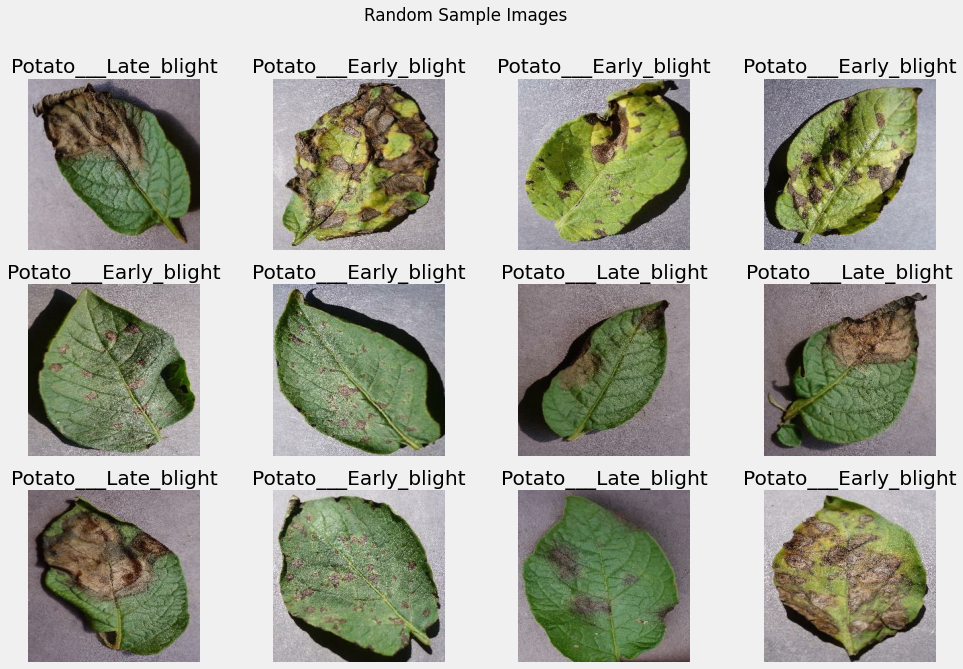

In [5]:
plt.figure(figsize = (15, 10))
plt.suptitle('Random Sample Images')
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.grid(False)
        plt.axis(False)

### Split dataset into training, validation, and testing datasets

In [6]:
# split dataset 80 train / 10 val / 10 test
def train_val_test_split_tf(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
    ds_size = int(len(dataset))
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=0)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = train_val_test_split_tf(dataset)

In [8]:
# fetching and caching to optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Preprocessing Layers

In [9]:
# resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Build the model

In [11]:
# define model architecture and build the model
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [12]:
# compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-03-09 22:48:28.027221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 18s 88ms/step - loss: 0.9122 - accuracy: 0.4525 - val_loss: 0.8630 - val_accuracy: 0.4219
Epoch 2/50
54/54 [==============================] - 2s 38ms/step - loss: 0.6845 - accuracy: 0.6766 - val_loss: 0.5676 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 2s 37ms/step - loss: 0.4280 - accuracy: 0.8192 - val_loss: 0.4543 - val_accuracy: 0.7760
Epoch 4/50
54/54 [==============================] - 2s 36ms/step - loss: 0.3506 - accuracy: 0.8603 - val_loss: 0.3234 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2613 - accuracy: 0.8991 - val_loss: 0.2003 - val_accuracy: 0.9167
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2503 - accuracy: 0.9061 - val_loss: 0.5130 - val_accuracy: 0.7708
Epoch 7/50
54/54 [==============================] - 2s 36ms/step - loss: 0.2555 - accuracy: 0.8991 - val_loss: 0.1971 - val_accuracy: 0.9219
Epoch 8/50
54/54 [=====

In [14]:
scores = model.evaluate(test_ds)
print(scores)

8/8 [==============================] - 3s 13ms/step - loss: 0.0313 - accuracy: 0.9871
[0.03133542463183403, 0.9870689511299133]


In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

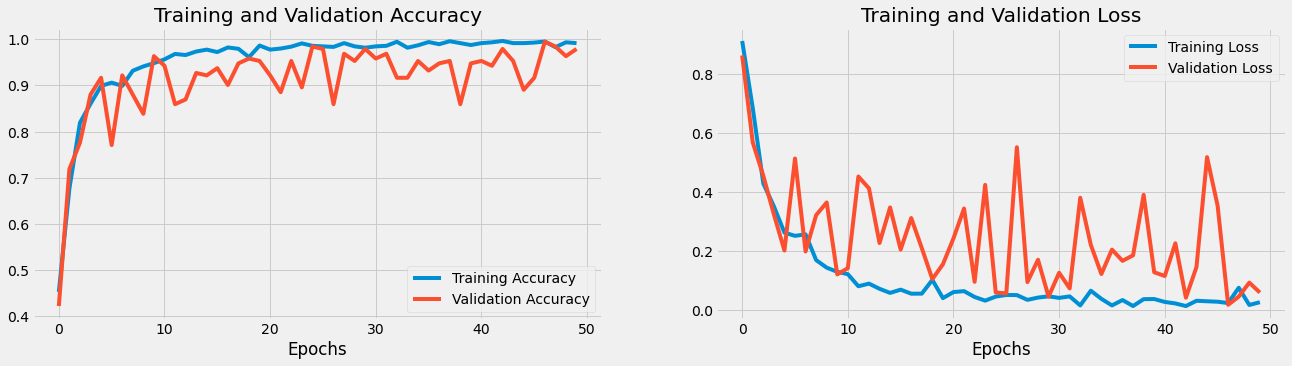

In [16]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


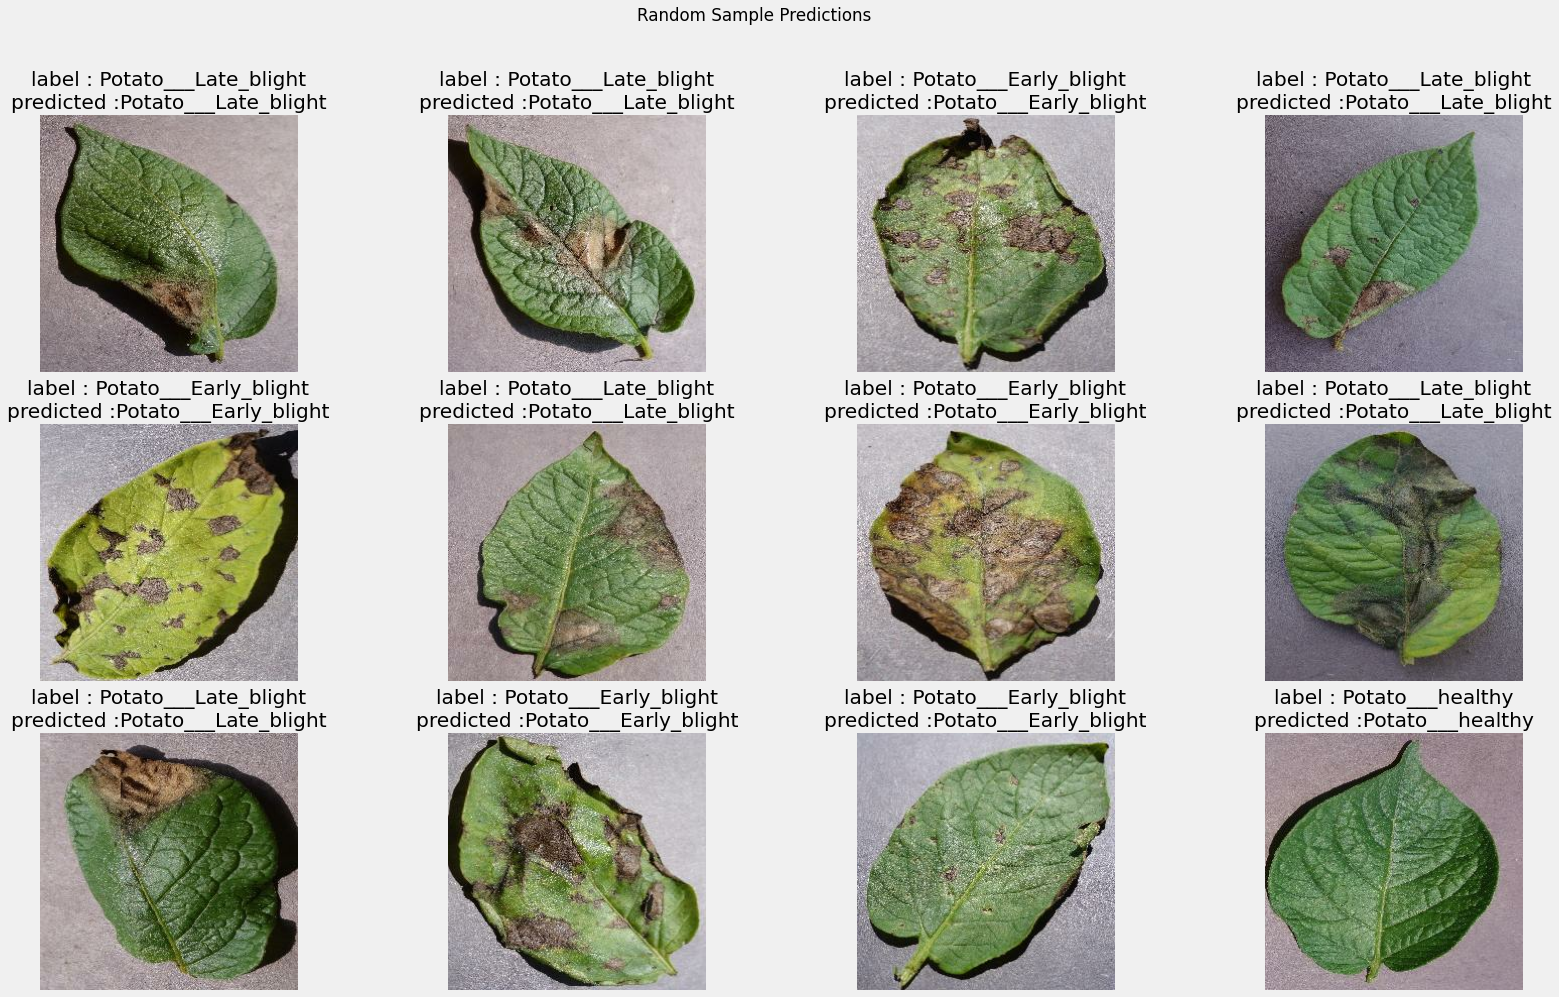

In [17]:
plt.figure(figsize = (25, 15))
plt.suptitle('Random Sample Predictions')
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        batch_prediction = model.predict(image_batch)
        plt.title(f'label : {class_names[label_batch[i]]}\npredicted :{class_names[np.argmax(batch_prediction[i])]}')
        plt.grid(False)
        plt.axis(False)

In [18]:
import datetime as dt
model_version = dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model.save(f'{model_version}-model.h5')

In [19]:
for image_batch, label_batch in dataset.take(1):
    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])

[9.9999976e-01 2.2972938e-07 5.6029350e-20]
